### Implementing Markov Chain Monte Carlo approach's Gibbs Sampling on generated data for COVID detection

In [1]:
# Install required packages
!pip install ipynb
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import time
import random
import numpy as np
import math
from google.colab import drive
from collections import Counter


In [16]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/Motif-Detection/"
input_path = base_path + "Data/"
covid_data_path = base_path + "Covid-Detection/Data/"
result_path = base_path + "Covid-Detection/Results/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define path to fetch the ipynb file
import sys
sys.path.insert(1, r'/content/drive/MyDrive/Motif-Detection/Py-files/Utils/')

# Import ipynb needed to access required functions
import import_ipynb
from info_content_ops import compute_information_content, obtain_info_content_per_column
from file_io import read_sequences_from_input_file, save_prediction_results_to_respective_files, save_generated_data_to_respective_files
from visualization import find_count_of_threshold_matched_sequences, compute_normalized_motif_counts, plot_motif_match_observations, visualize_sequence_generation_times, visualize_motif_generation_times


In [5]:
# Function to generate a random sequence of certain length based on nucleotide probabilities
# Input: sequence_length (Integer), nucleotide_prob (Integer array of size 4)
# Output: sequence (String of length sequence_length)

def generate_sequence(sequence_length, nucleotide_prob):
	sequence = []
  
	for i in range(0, sequence_length):
		random_probability = random.random()
		if random_probability < nucleotide_prob[0]:
			sequence.append(nucleotides[0])
		elif random_probability < nucleotide_prob[0] + nucleotide_prob[1]:
			sequence.append(nucleotides[1])
		elif random_probability < nucleotide_prob[0] + nucleotide_prob[1] + nucleotide_prob[2]:
			sequence.append(nucleotides[2])
		else:
			sequence.append(nucleotides[3])
	 
	return ''.join(sequence)


In [6]:
# Function to plant a randomly chosen motif at a random position in the given sequence
# Input: seq_to_modify (String), motifs (Array of motif Strings), motif_length (Integer), 
# 			 sequence_length (Integer), sequence_count (Integer (Max. no. of motifs available))
# Output: modified_sequence (String which is obtained by inserting randomized_motif in seq_to_modify)

def plant_motifs_in_sequence(seq_to_modify, motifs, motif_length, sequence_length, sequence_count):
	random_plant_position = random.randrange(0, sequence_length - motif_length)
	random_motif_position = random.randrange(0, sequence_count)
	modified_sequence = seq_to_modify[:random_motif_position] + motifs[random_motif_position] + seq_to_modify[random_motif_position + motif_length:]
	
	return modified_sequence, random_motif_position


In [7]:
# Function to generate sequence_count no. of random sequences of size sequence_length
# Input: sequence_count (Integer), sequence_length (Integer), nucleotide_prob (List)
# Output: sequences (List of sequence_count no. of sequences each of sequence_length size)
#         generation_time (Float describing the time taken to generate sequences)

def generate_sequences_of_given_count(sequence_count, sequence_length, nucleotide_prob):
  start_time = time.perf_counter()
  sequences = []
  
  for count in range(0, sequence_count):
    generated_sequence = generate_sequence(sequence_length, nucleotide_prob)
    sequences.append(generated_sequence)
  print("\nNo. of sequences: ", len(sequences))  
  print("A sample sequence looks like: ", sequences[0])
  end_time = time.perf_counter()
  generation_time = round(end_time - start_time, 2)

  return sequences, generation_time


In [8]:
# Function to compute the Position Weight Matrix (PWM) for N-1 sequences
# Input: dna_seqeunces, no_of_sequences, motif_length, sequence_length, motif_sites 
# Output: Returns pwm and ignored sequence

def compute_position_weight_matrix(dna_seqs, no_of_seqs, motif_len, seq_len, motif_sites):

  # To ignore a sequence, we generate a random number
  random.seed(time.time())
  ignored_seq = random.randrange(0, no_of_seqs)

  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  pwm = np.zeros((4, motif_len))

  # Indexing the N-1 sequences
  idx = 0

  for seq_idx in range(0, no_of_seqs):

    # We ignore the previously selected random sequence
    if seq_idx == ignored_seq:
        continue

    else:
      for m_len in range(0, motif_len):
        value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
        if value == nucleotides[0]:
          pwm[0][m_len] += 1
        elif value == nucleotides[1]:
          pwm[1][m_len] += 1
        elif value == nucleotides[2]:
          pwm[2][m_len] += 1
        elif value == nucleotides[3]:
          pwm[3][m_len] += 1
    idx += 1

  return pwm/(no_of_seqs - 1), ignored_seq


In [9]:
# Function to find max PWM and max info content
# Input: iterations, dna_sequences, motif_length, sequence_length, motif_sites
# Output: Returns information content, pwm and information vector

def compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, acceptable_info_content = 1.7):

  # Declaring required variables
  added_prediction, max_info_content, iter_count = False, 0, 0
  information_vector = [['IC'], ['sites']]
  no_of_seqs = len(dna_sequences)
  
  print("Iterations to be completed: ", iterations)

  # Runs multiple iterations to obtain right values
  for iteration in range(0, iterations):
    
    # Tracking iterations
    iter_count += 1
    if iter_count % 100 == 0:
      print("Completed ", iter_count, " iterations")

    # Finding the Position Weight Matrix (PWM) for N-1 sequences
    pwm, ignored_seq = compute_position_weight_matrix(dna_sequences, no_of_seqs, motif_length, sequence_length, motif_sites)

    # Predicting the site in the ignored sequence using the PWM
    predicted_site_in_ignored_seq = predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_length, sequence_length)

    # Adding the predicted site to the list if it is not yet added
    if added_prediction == False:
      motif_sites.insert(ignored_seq, predicted_site_in_ignored_seq)
      added_prediction = True
    else:
      motif_sites[ignored_seq] = predicted_site_in_ignored_seq
    motif_sites_temp = motif_sites[:]

    # Computing the information content of the prediction in the current iteration
    information_vector[1].append(motif_sites_temp)
    info_content, pwm = compute_information_content(nucleotides, freq, motif_sites, dna_sequences, motif_length, no_of_seqs, pwm)
    information_vector[0].append(info_content)

    # Updating max. information content value
    if info_content > max_info_content:
      max_info_content = info_content
      max_pwm = pwm

    if info_content > (acceptable_info_content * motif_length):
      break

  # Updating info_content & pwm with the max. values respectively
  info_content = max_info_content
  pwm = max_pwm
  
  return info_content, max_pwm, information_vector


In [10]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: dna_seqeunces, ignored_seq, pwm, motif_length, sequence_length
# Output: Returns the predicted site

def predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_len, sequence_len):

  # Obtaining all possible prediction candidates of given motif length
  prediction_candidates = []
  for i in range(0, sequence_len - motif_len + 1):
    prediction_candidates.append((dna_sequences[ignored_seq])[i:i + motif_len])

  # Generating probabilities for all candidates to find the best possible prediction
  candidate_probabilities = []
  for pred_idx in range(0, len(prediction_candidates)):
    frequency, weighted_frequency = 1, 1

    for m_len in range(0, motif_len):
      value = prediction_candidates[pred_idx][m_len]
      if value == nucleotides[0]:
        frequency *= freq[0]
        weighted_frequency *= pwm[0][m_len]
      elif value == nucleotides[1]:
        frequency *= freq[1]
        weighted_frequency *= pwm[1][m_len]
      elif value == nucleotides[2]:
        frequency *= freq[2]
        weighted_frequency *= pwm[2][m_len]
      elif value == nucleotides[3]:
        frequency *= freq[3]
        weighted_frequency *= pwm[3][m_len]
    candidate_probabilities.append(weighted_frequency / frequency)

  # Normalizing the probabilities to obtain the predicted site
  normalized_probabilities = list(candidate_probabilities / sum(candidate_probabilities))
  predicted_site = normalized_probabilities.index(max(normalized_probabilities))
  return predicted_site


In [11]:
# Function to find motif from pwm using the sequences and motif length
# Input: pwm, no_of_seqs, motif_length
# Output: Returns motif result and profile matrix

def find_motif_from_pwm(pwm, no_of_seqs, motif_length):

  # Obtaining the motif from given dna sequences using Position Weight Matrix
  profile_matrix = np.transpose(pwm) * no_of_seqs
  motif_temp = []
  for m_len in range(0, motif_length):
    values_at_mlen = list(profile_matrix[m_len])
    max_value = max(values_at_mlen)

    # As two nucleotides may have equal probability of occurrence, we check if the max_value appears more than once
    max_value_indices = []
    for idx in range(0, len(values_at_mlen)):
      if values_at_mlen[idx] == max_value:
        max_value_indices.append(idx)
    
    if len(max_value_indices) > 1:
      motif_index = random.choice(max_value_indices)
    else:
      motif_index = values_at_mlen.index(max(values_at_mlen))
    
    motif_temp.append(nucleotides[motif_index])
  motif_result = ''.join(motif_temp)

  return motif_result, profile_matrix


In [12]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/Motif-Detection/"
input_path = base_path + "Data/"
covid_data_path = base_path + "Covid-Data/"
result_path = base_path + "Covid-Detection/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Define constants needed
nucleotides = ['A', 'G', 'T', 'C']
nucleotide_prob = [0.25, 0.25, 0.25, 0.25]
freq = [0.25, 0.25, 0.25, 0.25]

# ICPC: information_content_per_column = float(input()) # [0, 2]
# Typically rounded down to two decimal digits
icpc = 1.02 

# Generally 5-20 base pairs long
motif_length_to_add = 30
motif_length_to_find = 15

# General length of a dna sequence is 150 base pairs
sequence_length = 300

# For analysis, we generate different no. of dna sequences
sequence_counts = [1000, 5000, 10000, 50000, 100000]

# For analysis, we store sequence generation times for various length 
sequence_generation_times = []

# Application to detect COVID 19 motif in the DNA & find the percentage match
covid_motif = "TTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAA"
random_motif = covid_motif    #Adding the COVID motif completely to the data
#covid_motif_start_pos = random.randint(0, len(covid_motif) - motif_length_to_find)


In [14]:
# Obtain probability associated with information content per column
icpc_path = input_path + "icpc_p_map.txt"
icpc_prob = obtain_info_content_per_column(icpc_path)
icpc_probability = [icpc_prob[i][1] for i in range(0, len(icpc_prob)) if round(icpc, 2) == icpc_prob[i][0]]
icpc_probability = icpc_probability[0]

# Obtain normalized probabilities by performing (1 - prob) / (1 + max_icpc)
normalized_prob = (1 - icpc_probability) / 3.0


In [17]:
# Generate DNA sequences of different sequence counts
for sequence_count in sequence_counts:

  # Start the timer to track generation times
  start_time = time.perf_counter()
  
  # Generate sequences of given sequence count
  sequences = []
  for i in range(0, sequence_count):
    seq = generate_sequence(sequence_length, nucleotide_prob)
    sequences.append(seq)
  
  # Generate 20 random motifs from the COVID 19 motif sequence
  generated_motifs = []
  for i in range(0, motif_length_to_add):
    motif_prob = [normalized_prob, normalized_prob, normalized_prob, normalized_prob]
    for j in range(0, len(nucleotides)):
      if random_motif[i] == nucleotides[j]:
        motif_prob[j] = icpc_probability
    generated_motif = generate_sequence(sequence_count, motif_prob)
    generated_motifs.append(generated_motif)

  # Generate sequence_count no. of random motifs of size motif_length
  motifs = []
  for i in range(0, sequence_count):
    motif = []
    for j in range(0, motif_length_to_add):
      motif.append(generated_motifs[j][i])
    motifs.append(''.join(motif))

  print("\nNo. of motifs: ", len(motifs))
  print("A motif looks like: ", motifs[0])

  # Constructing the Positional Weight Matrix or Profile Matrix
  # to analyze the counts associated with nucleotides
  profile_matrix = []
  for i in range(0, motif_length_to_add):
    counts = [0, 0, 0, 0]
    for j in range(0, sequence_count):
      for k in range(0, len(nucleotides)):
        if motifs[j][i] == nucleotides[k]:
          counts[k] = counts[k] + 1
    profile_matrix.append(counts)

  print("\nNo. of rows in profile_matrix: ", len(profile_matrix))
  print("No. of columns in profile matrix: ", len(profile_matrix[0]))
  print("A sample row in profile matrix looks like: ", profile_matrix[0], "\n")

  # Plant as many motifs as sequence_count in sequences to enforce differential privacy
  modified_sequences = []
  random_positions = []
  for i in range(0, sequence_count):
    modified_sequence, random_position = plant_motifs_in_sequence(sequences[i], motifs, motif_length_to_add, sequence_length, sequence_count)
    modified_sequences.append(modified_sequence)
    random_positions.append(random_position)

  # Save results to respective files
  save_generated_data_to_respective_files(covid_data_path, sequence_count, modified_sequences, random_motif, random_positions, profile_matrix)

  # End the timer to stop and save the total generation time
  end_time = time.perf_counter()
  sequence_generation_times.append(round(end_time - start_time, 2))
  print("**********************************")



No. of motifs:  1000
A motif looks like:  TTCACGGAGGCAACGCGGTTTCCGATCGTG

No. of rows in profile_matrix:  30
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [58, 67, 812, 63] 

**********************************

No. of motifs:  5000
A motif looks like:  TTCACCGGGCCCACCCAGAGAAAGGTAGAG

No. of rows in profile_matrix:  30
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [299, 314, 4076, 311] 

**********************************

No. of motifs:  10000
A motif looks like:  TTAAGAGAGACCTCGCTGGGTACGATCGAA

No. of rows in profile_matrix:  30
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [636, 612, 8173, 579] 

**********************************

No. of motifs:  50000
A motif looks like:  TTCACCGAGTCCACGCCGAGTACGATCGAG

No. of rows in profile_matrix:  30
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [3234, 3041, 40728, 2997] 

*********************************

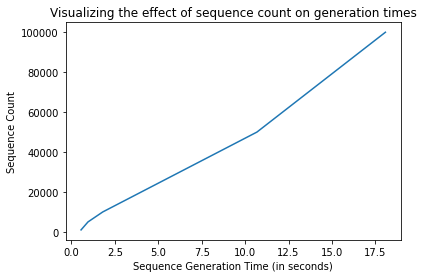

In [18]:
# Plot the generation times and sequence_count to visualize data generation times
visualize_sequence_generation_times(sequence_generation_times, sequence_counts)


In [19]:
# Executing Gibbs algorithm and store motif results obtained
motif_results, motif_detection_times = [], []
profile_matrices, all_dna_sequences = [], []
idx = 0

for sequence_count in sequence_counts:

  # Start the timer to track motif detection times
  start_time = time.perf_counter()

  # Read DNA data from input files
  dna_sequences = read_sequences_from_input_file(covid_data_path, sequence_count)
  all_dna_sequences.append(dna_sequences)
  
  no_of_seqs = len(dna_sequences)
  print("\nNo. of DNA sequences: ", no_of_seqs)

  # As in Gibbs sampling, we select random starting points and 
  # generate motif site for all the remaining sequences
  motif_sites = []
  for i in range(0, no_of_seqs-1):
    random_start_site = random.randrange(0, sequence_length - motif_length_to_find)
    motif_sites.append(random_start_site)

  # Implementing Gibbs algorithm with several iterations
  iterations =  100
  info_content, pwm, information_vector = compute_max_pwm_and_ic(iterations, dna_sequences, motif_length_to_find, sequence_length, motif_sites)
  motif_result, profile_matrix = find_motif_from_pwm(pwm, no_of_seqs, motif_length_to_find)
  motif_results.append(motif_result)
  profile_matrices.append(profile_matrix)
  save_prediction_results_to_respective_files(result_path, motif_result, sequence_count, information_vector, profile_matrix)

  # Analyzing the results obtained
  print("Motif discovered: ", motif_results[idx], "\n")
  idx += 1

  # End the timer to track motif detection times
  end_time = time.perf_counter()
  motif_detection_times.append(round(end_time - start_time, 2))
  print("**********************************")



No. of DNA sequences:  1000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  CCGTGTCCGTGGGGC 

**********************************

No. of DNA sequences:  5000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  ACGAGCGGTCGTCCG 

**********************************

No. of DNA sequences:  10000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  GGTGTTGTGAACTCC 

**********************************

No. of DNA sequences:  50000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  GGGCGTTAACTATGT 

**********************************

No. of DNA sequences:  100000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  TCGCCTAGAACCTTC 

**********************************


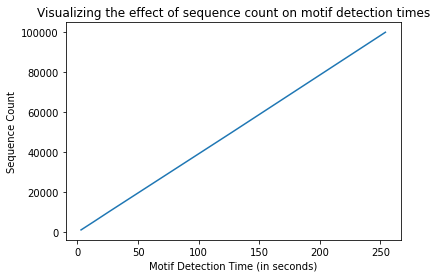

In [20]:
# Plot the motif detection times and sequence_count for visualization
visualize_motif_generation_times(motif_detection_times, sequence_counts)


In [21]:
# Finding percentage match between motif and the DNA sequences
motif_counts = find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results)
normalized_motif_counts = compute_normalized_motif_counts(motif_counts)

# FInding the mode to see the common amount of match
total_percent_counts = []
for key in normalized_motif_counts.keys():
  for each_percent in normalized_motif_counts[key]:
    total_percent_counts.append(each_percent)

max_data_percent_matched = Counter(total_percent_counts)
max_value = max_data_percent_matched.most_common(1)
max_count = max_value[0][0]
print("\n\nIn the dataset, ", (max_count * 100), "% of records matched well with the COVID motif")
print("Hence, we can specualte that those individuals need immediate medical supervision")


Original motif counts:
[67, 54, 54, 54, 73] for  1000  dna sequences
[331, 309, 340, 340, 316] for  5000  dna sequences
[616, 617, 611, 611, 662] for  10000  dna sequences
[3173, 3109, 3074, 3074, 3070] for  50000  dna sequences
[6275, 6254, 6257, 6257, 6248] for  100000  dna sequences


Normalized motif counts:
[0.067, 0.054, 0.054, 0.054, 0.073]
[0.0662, 0.0618, 0.068, 0.068, 0.0632]
[0.0616, 0.0617, 0.0611, 0.0611, 0.0662]
[0.06346, 0.06218, 0.06148, 0.06148, 0.0614]
[0.06275, 0.06254, 0.06257, 0.06257, 0.06248]


In the dataset,  5.4 % of records matched well with the COVID motif
Hence, we can specualte that those individuals need immediate medical supervision


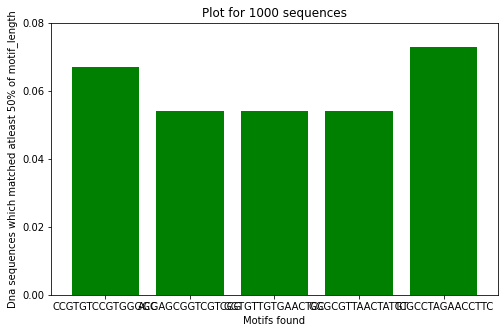

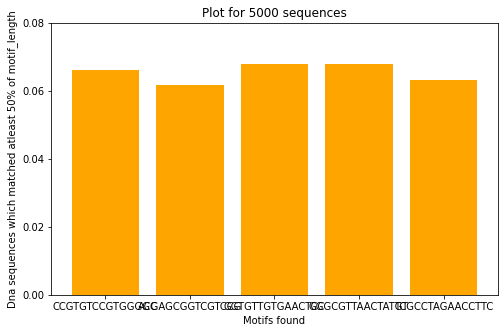

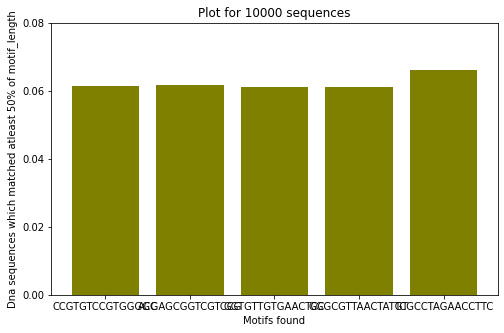

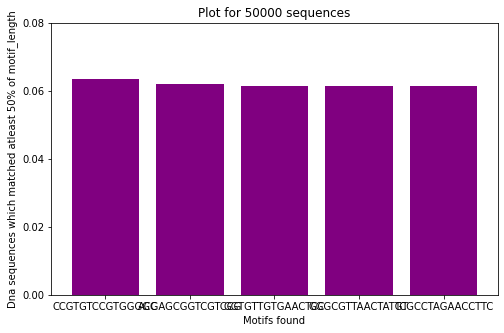

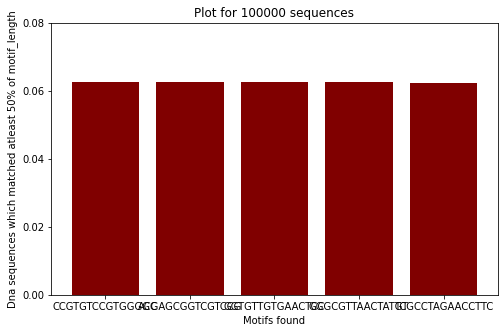

In [22]:
# Visualization
plot_motif_match_observations(motif_results, normalized_motif_counts)
